# Test loss based strategy for Polynomial prediction with a heterogenous MLP model

### env management

In [ ]:
%env "WANDB_NOTEBOOK_NAME" "19_hetero_poly_test_strat.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: "WANDB_NOTEBOOK_NAME"="19_hetero_poly_test_strat.ipynb"
env: WANDB_SILENT=True
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.3


### imports and setup

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

import os
import sys
import logging
import wandb

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='vlag', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
class MidpointNormalize(Normalize):
    """
    Normalize and shift the colormap to center 0
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin, vmax, midpoint) = self.vmin, self.vmax, self.midpoint
        if vmin is None or vmax is None:
            vmin, vmax = np.min(value), np.max(value)
        if midpoint is None:
            midpoint = (vmin + vmax) / 2
        result = np.ma.masked_array(np.interp(value, [vmin, midpoint, vmax], [0, 0.5, 1]))
        if is_scalar:
            result = np.atleast_1d(result)[0]
        return result

### config

In [ ]:
input_size = 1
hidden_sizes = [5, 5] 
output_size = 1
initial_activation_list = [jax.nn.tanh, jax.nn.relu]
activation_list = [jax.nn.tanh, jax.nn.relu]
bias = False
num_epochs = 25000
intervene_every = 50
seed = 0
key = jax.random.PRNGKey(seed)
threshold = 1e-4
grad_norm_threshold = 1e-3
n_samples = 20000
test_size = 0.2
learning_rate = 3e-4

act_string = "_".join([act.__name__ for act in initial_activation_list])

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                seed=seed)

2024-06-12 11:31:35.212248: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'intervene_every': intervene_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [ ]:
# jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
Description = f"Hetero_{act_string}_poly_test_strat__no_bias_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{intervene_every}_{threshold}_{seed}"
fig_folder = f"../figures/{Description}"
out_folder = f"../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

### logging

In [ ]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 4
Description: Hetero_tanh_relu_poly_test_strat__no_bias_5_5_25000_50_0.0001_0
jax backend: gpu
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]


In [ ]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


### data

In [ ]:
def poly(x):
    """
    7th degree polynomial to predict
    """
    return (x - 3)*(x - 2)*(x - 1)*x*(x + 1)*(x + 2)*(x + 3)

In [ ]:
x = jnp.linspace(-3, 3, n_samples).reshape(-1, 1)
y = poly(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)


Text(0.5, 0.98, 'Data')

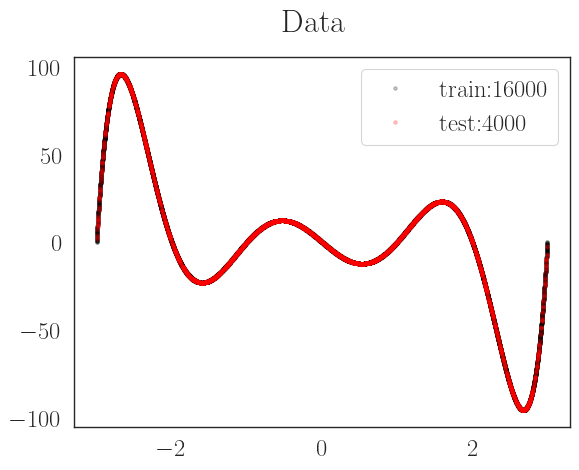

In [ ]:
plt.plot(x_train, y_train, "k.", alpha=0.2, label=f"train:{len(x_train)}")
plt.plot(x_test, y_test, "r.", alpha = 0.2, label=f"test:{len(x_test)}")
plt.legend()
plt.suptitle("Data")

### training and eval scheme

In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    """
    Optimizer initialization that filters for float arrays in the jax pytrees
    """
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
@eqx.filter_jit()
def test_step(mlp, x, y):
    return compute_loss(mlp, x, y)[0]

In [ ]:
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))

### initializing MLP

In [ ]:
mlp = CustomMLP(config)

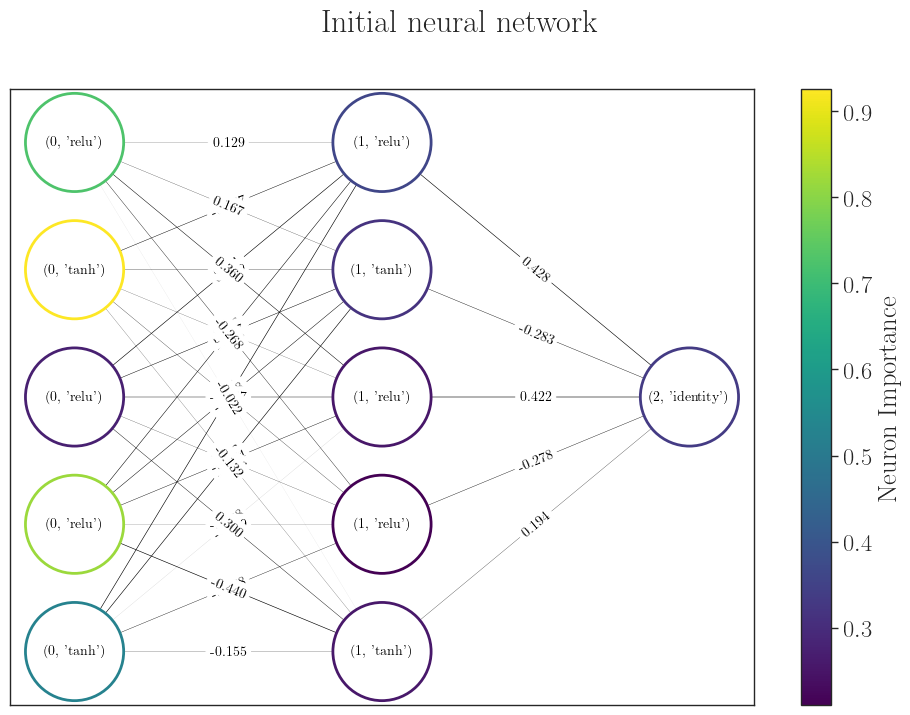

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.suptitle("Initial neural network")
plt.savefig(f"{fig_folder}/initial_graph.png")
wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

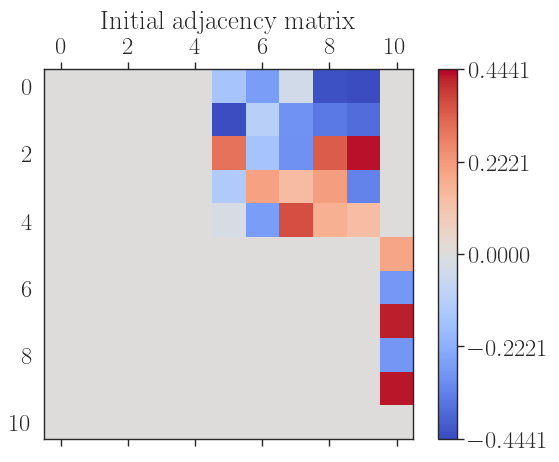

In [ ]:
max_wt = np.max(np.abs(initial_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(initial_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

### initializing optimizer

In [ ]:
opt = optax.adabelief(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

### training

In [ ]:
train_loss_history = []
test_loss_history = []
node_history = []
grad_norm_history = []
graph_history = []
update_history = []

test_loss = np.inf # initialize test loss to infinity

In [ ]:
for epoch in range(num_epochs):
    train_loss, mlp, opt_state = train_step(mlp, x_train, y_train, opt_state, opt.update)
    _, grads  = compute_loss(mlp, x_train, y_train)
    grad_norm_val = grad_norm(grads)
    n_neurons = sum(mlp.get_shape())

    logging.info(f"Epoch {epoch :03d}, Loss: {train_loss.item()}, Neurons: {n_neurons}, Grad norm: {grad_norm_val :.3e}")
    wandb.log({"train_loss": train_loss.item(), "neurons": n_neurons, "grad_norm": grad_norm_val})
    train_loss_history.append((epoch, train_loss))
    grad_norm_history.append((epoch,grad_norm_val))
    node_history.append((epoch, n_neurons))

    if test_loss < threshold:
        logging.info(f"Threshold reached, stopping training at epoch {epoch}")
        wandb.log({"threshold reached": epoch})
        break

    # key, add_key, sub_key = jax.random.split(key,3)

    if (epoch + 1) % intervene_every == 0 or grad_norm_val < grad_norm_threshold:
        test_loss = test_step(mlp, x_test, y_test)
        logging.info(f"Epoch {epoch :03d}, Test loss: {test_loss.item()}")
        wandb.log({"test_loss": test_loss.item()})
        test_loss_history.append((epoch,test_loss))
    
    

    if grad_norm_val < grad_norm_threshold/10:
        logging.info(f"Gradient norm below threshold, stopping training at epoch {epoch}")
        wandb.log({"grad_norm_threshold": epoch})
        break

Epoch 000, Loss: 1521.5067138671875, Neurons: 11, Grad norm: 3.391e+01
Epoch 001, Loss: 1521.463134765625, Neurons: 11, Grad norm: 3.391e+01
Epoch 002, Loss: 1521.4171142578125, Neurons: 11, Grad norm: 3.392e+01
Epoch 003, Loss: 1521.3687744140625, Neurons: 11, Grad norm: 3.393e+01
Epoch 004, Loss: 1521.318359375, Neurons: 11, Grad norm: 3.394e+01
Epoch 005, Loss: 1521.2655029296875, Neurons: 11, Grad norm: 3.394e+01
Epoch 006, Loss: 1521.2103271484375, Neurons: 11, Grad norm: 3.395e+01
Epoch 007, Loss: 1521.1529541015625, Neurons: 11, Grad norm: 3.397e+01
Epoch 008, Loss: 1521.09326171875, Neurons: 11, Grad norm: 3.398e+01
Epoch 009, Loss: 1521.0313720703125, Neurons: 11, Grad norm: 3.399e+01
Epoch 010, Loss: 1520.967041015625, Neurons: 11, Grad norm: 3.400e+01
Epoch 011, Loss: 1520.9005126953125, Neurons: 11, Grad norm: 3.402e+01
Epoch 012, Loss: 1520.831787109375, Neurons: 11, Grad norm: 3.403e+01
Epoch 013, Loss: 1520.7607421875, Neurons: 11, Grad norm: 3.405e+01
Epoch 014, Loss: 1

In [ ]:
np.savetxt(f"{out_folder}/neurons.txt", node_history)
np.savetxt(f"{out_folder}/train_loss.txt", train_loss_history)
np.savetxt(f"{out_folder}/test_loss.txt", test_loss_history)
np.savetxt(f"{out_folder}/grad_norm.txt", grad_norm_history)

### evaluation

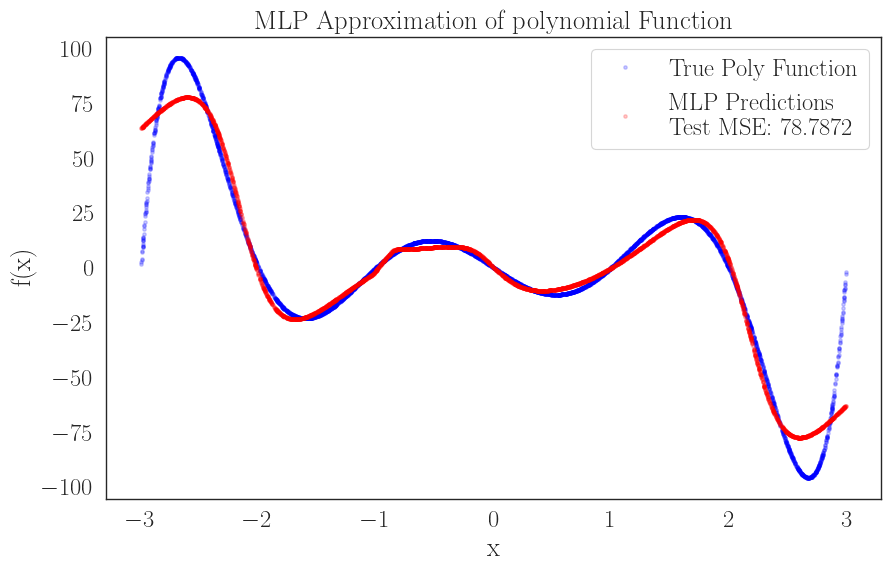

In [ ]:
y_pred = jax.vmap(mlp)(x_test)
test_mse = jnp.mean((y_pred - y_test) ** 2)
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, "b.", alpha=0.2, label="True Poly Function")
plt.plot(x_test, y_pred, "r.", alpha=0.2, label="MLP Predictions\n Test MSE: {:.4f}".format(test_mse))
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("MLP Approximation of polynomial Function")
plt.savefig(f"{fig_folder}/polynomial_approximation.png")
wandb.log({"polynomial approximation": wandb.Image(plt, caption="polynomial approximation")})


In [ ]:
update_history

[]

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

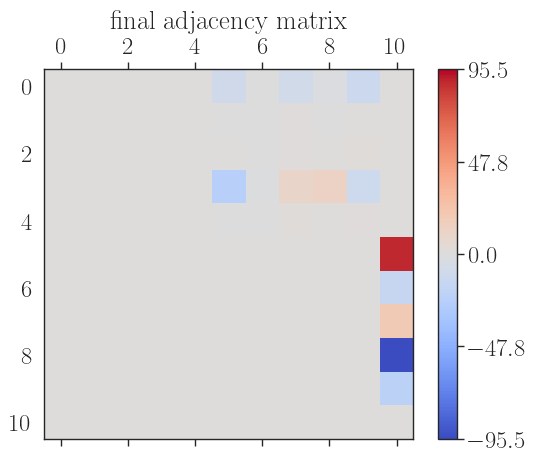

In [ ]:
max_wt = np.max(np.abs(final_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(final_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

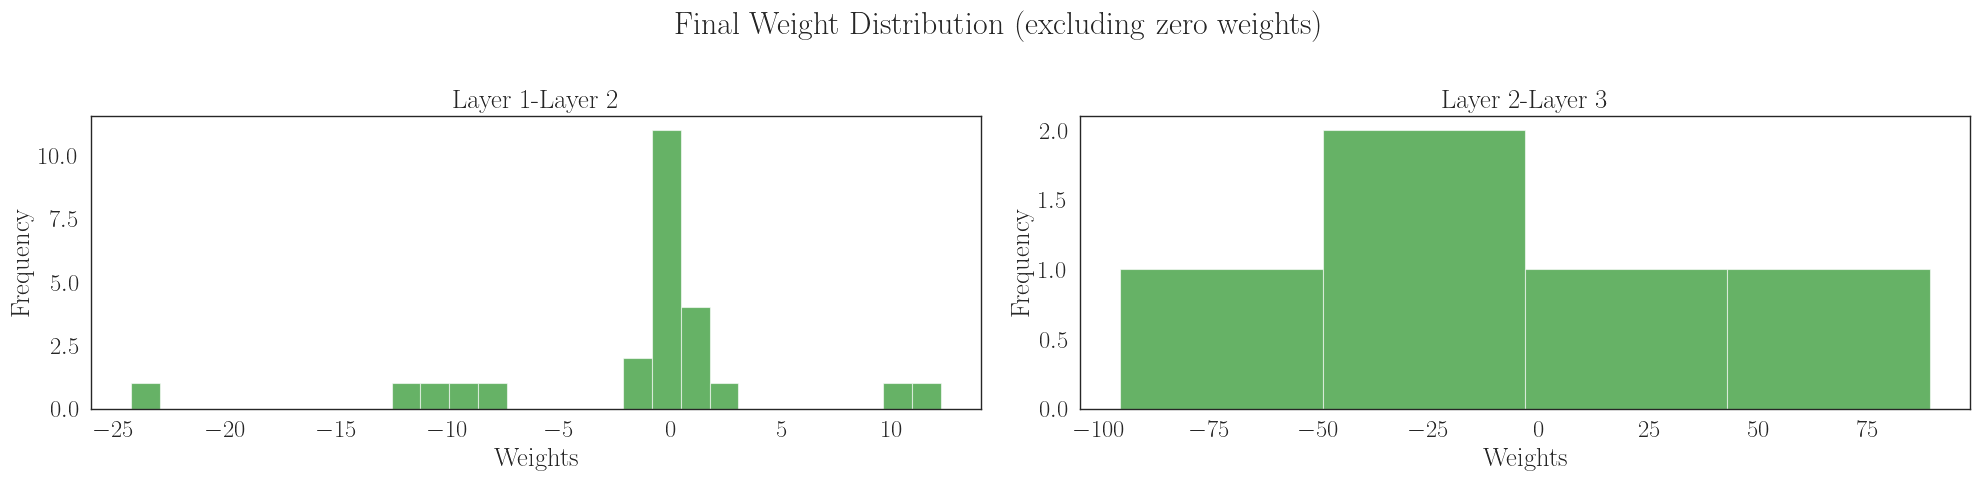

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum(mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

# Display the figure with its subplots
plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.show()

In [ ]:
train_epochs, train_loss = zip(*train_loss_history)
test_epochs, test_loss = zip(*test_loss_history)
grad_epochs, grad_norm_val = zip(*grad_norm_history)
node_epochs, n_neurons = zip(*node_history)

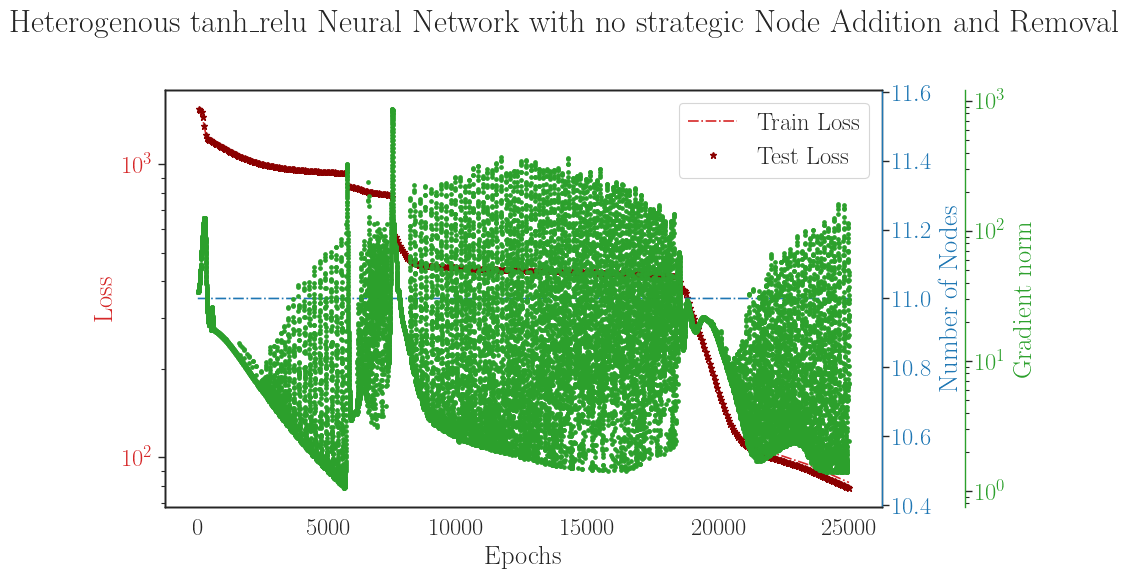

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color)
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

# ax1.set_xscale("log")
ax1.legend()
plt.suptitle(f"Heterogenous {act_string} Neural Network with no strategic Node Addition and Removal")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

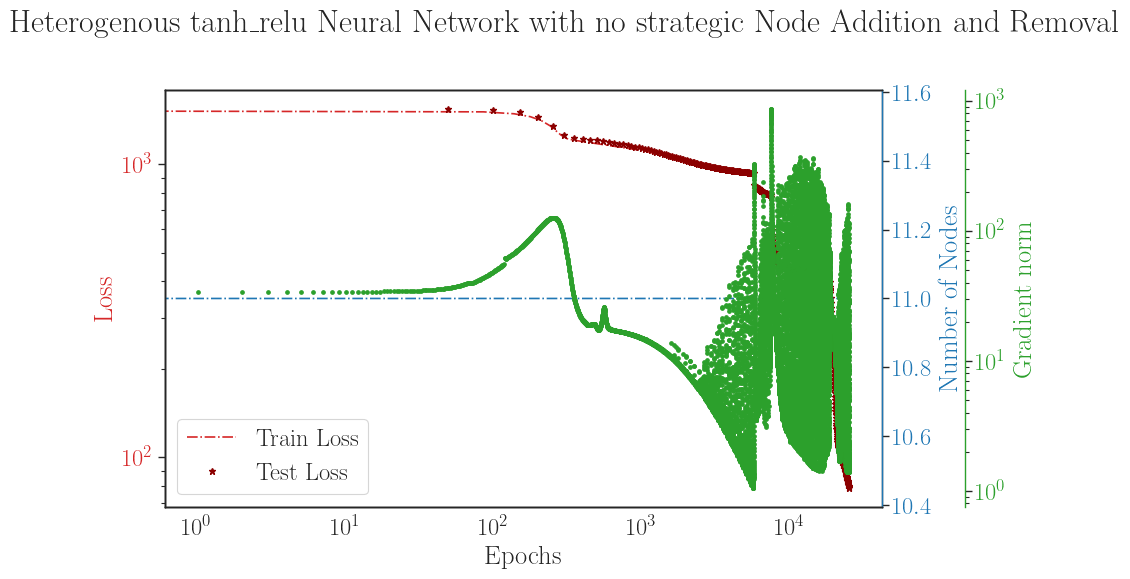

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color)
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

ax1.set_xscale("log")

plt.suptitle(f"Heterogenous {act_string} Neural Network with no strategic Node Addition and Removal")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve_loglog.png")

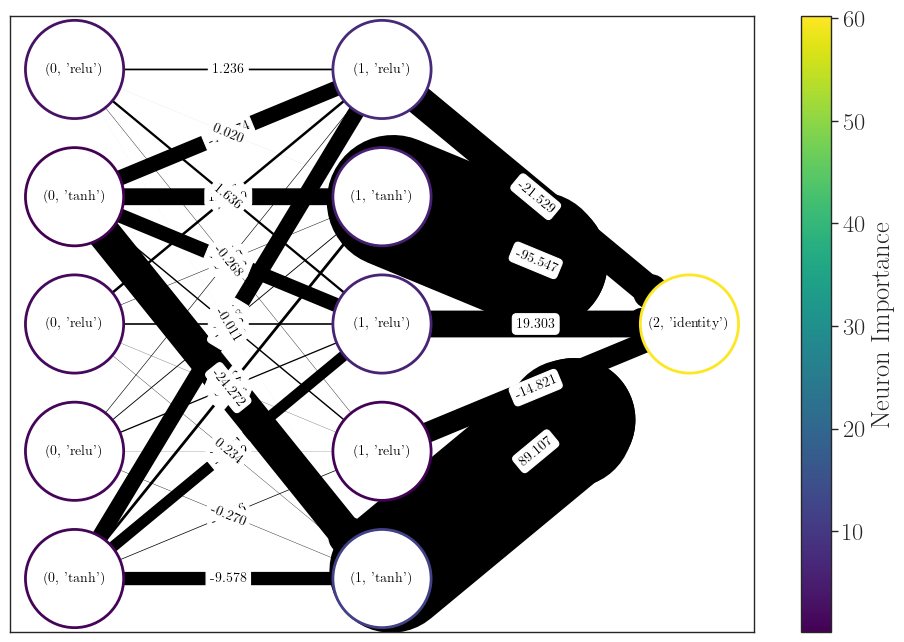

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [ ]:
wandb.finish()